In [1]:
import pandas as pd

import sklearn

import numpy as np
import xgboost as xgb

In [2]:
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv("../data/processed/fhvhv_daily_counts_features.csv")

df['pickup_date'] = pd.to_datetime(df['pickup_date'])
# set PULocationID as categorical
df["PULocationID"] = df["PULocationID"].astype("category")

df.head()

,PULocationID,pickup_date,count,day_of_week,day_of_month,month,is_weekend,lag_1,lag_7,rolling_mean_3,...,rolling_max_30,expanding_mean,expanding_median,expanding_std,expanding_min,expanding_max,diff_1,diff_7,day_of_week_sin,day_of_week_cos
0,1,2022-02-01,0,1,1,2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530
1,1,2022-02-02,0,2,2,2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394356,0.918958
2,1,2022-02-03,0,3,3,2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571268,0.820763
3,1,2022-02-04,0,4,4,2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967
4,1,2022-02-05,0,5,5,2,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.848644,0.528964


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
HOLDOUT_LENGTH_W = 1

HOLDOUT_DATE_START = df.pickup_date.max() - pd.Timedelta(weeks=HOLDOUT_LENGTH_W)

HOLDOUT_DATE_START

Timestamp('2023-09-23 00:00:00')

In [6]:
holdout_df = df[df.pickup_date > HOLDOUT_DATE_START]

df = df[df.pickup_date <= HOLDOUT_DATE_START]

In [7]:
df.head()

,PULocationID,pickup_date,count,day_of_week,day_of_month,month,is_weekend,lag_1,lag_7,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_median_3,rolling_median_7,rolling_median_14,rolling_median_30,rolling_std_3,rolling_std_7,rolling_std_14,rolling_std_30,rolling_min_3,rolling_min_7,rolling_min_14,rolling_min_30,rolling_max_3,rolling_max_7,rolling_max_14,rolling_max_30,expanding_mean,expanding_median,expanding_std,expanding_min,expanding_max,diff_1,diff_7,day_of_week_sin,day_of_week_cos
0,1,2022-02-01,0,1,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530
1,1,2022-02-02,0,2,2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394356,0.918958
2,1,2022-02-03,0,3,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571268,0.820763
3,1,2022-02-04,0,4,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967
4,1,2022-02-05,0,5,5,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.848644,0.528964


In [8]:
def predict_baseline(df, alpha=0.5):
    return df['lag_1'] + alpha * (df['lag_1'] - df['lag_7'])

In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))

In [10]:
HOLDOUT_DATE_START, HOLDOUT_LENGTH_W

(Timestamp('2023-09-23 00:00:00'), 1)

In [15]:
BACKTESTS = 3
BACKTESTS_LENGTH_W = 1

TRAIN_START = df.pickup_date.min() - pd.Timedelta(days=1)

TRAIN_LENGTH = df.pickup_date.max() - pd.Timedelta(weeks=BACKTESTS_LENGTH_W*BACKTESTS) - TRAIN_START


holdout_start = HOLDOUT_DATE_START
earliest_train_start = df.pickup_date.min()


# Calculate backtest periods
for i in range(BACKTESTS):
    backtest_end = holdout_start - pd.Timedelta(days=1)  # End date of backtest is one day before holdout starts
    backtest_start = backtest_end - pd.Timedelta(weeks=BACKTESTS_LENGTH_W) + pd.Timedelta(days=1)

    train_start = earliest_train_start + pd.Timedelta(weeks=BACKTESTS_LENGTH_W*(BACKTESTS - i-1))
    train_end = backtest_start - pd.Timedelta(days=1)

    print(f"Backtest {i+1}:")
    print(f"   Training Data: Start - {train_start.date()}, End - {train_end.date()}")
    print(f"   Backtest Data: Start - {backtest_start.date()}, End - {backtest_end.date()}")

    train_df = df[(df.pickup_date <= train_start) & (df.pickup_date >= train_end)]
    test_df = df[(df.pickup_date >= backtest_start) & (df.pickup_date <= backtest_end)]
    
    test_df['prediction'] = predict_baseline(test_df)
    
    print("RMSE for backtest {} is {}".format(i, rmse(test_df['count'], test_df['prediction'])))


    # Update the holdout start for the next backtest
    holdout_start = backtest_start #- pd.Timedelta(days=1)

Backtest 1:
   Training Data: Start - 2022-02-15, End - 2023-09-15
   Backtest Data: Start - 2023-09-16, End - 2023-09-22
RMSE for backtest 0 is 938.3971609439001
Backtest 2:
   Training Data: Start - 2022-02-08, End - 2023-09-08
   Backtest Data: Start - 2023-09-09, End - 2023-09-15
RMSE for backtest 1 is 1015.2250658227715
Backtest 3:
   Training Data: Start - 2022-02-01, End - 2023-09-01
   Backtest Data: Start - 2023-09-02, End - 2023-09-08
RMSE for backtest 2 is 880.6636491463449


/var/folders/1j/zwnv49_10lv7m7s34ngtk0kc0000gn/T/ipykernel_41177/249487860.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = predict_baseline(test_df)
/var/folders/1j/zwnv49_10lv7m7s34ngtk0kc0000gn/T/ipykernel_41177/249487860.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = predict_baseline(test_df)
/var/folders/1j/zwnv49_10lv7m7s34ngtk0kc0000gn/T/ipykernel_41177/249487860.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [48]:
test_df

,PULocationID,pickup_date,count,day_of_week,day_of_month,month,is_weekend,lag_1,lag_7,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_median_3,rolling_median_7,rolling_median_14,rolling_median_30,rolling_std_3,rolling_std_7,rolling_std_14,rolling_std_30,rolling_min_3,rolling_min_7,rolling_min_14,rolling_min_30,rolling_max_3,rolling_max_7,rolling_max_14,rolling_max_30,expanding_mean,expanding_median,expanding_std,expanding_min,expanding_max,diff_1,diff_7,day_of_week_sin,day_of_week_cos,prediction
593,1,2023-09-17,0,6,17,9,1,0.0,0.0,0.000000,0.000000,0.285714,0.166667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.611250,0.461133,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.070513,0.0,0.410335,0.0,8.0,0.0,0.0,-0.299363,-0.954139,0.0
594,1,2023-09-18,0,0,18,9,0,0.0,0.0,0.000000,0.000000,0.285714,0.166667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.611250,0.461133,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.070400,0.0,0.410016,0.0,8.0,0.0,0.0,-0.485302,-0.874347,0.0
595,1,2023-09-19,0,1,19,9,0,0.0,0.0,0.000000,0.000000,0.214286,0.166667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.578934,0.461133,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.070288,0.0,0.409697,0.0,8.0,0.0,0.0,-0.651372,-0.758758,0.0
596,1,2023-09-20,0,2,20,9,0,0.0,0.0,0.000000,0.000000,0.214286,0.166667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.578934,0.461133,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.070175,0.0,0.409379,0.0,8.0,0.0,0.0,-0.790776,-0.612106,0.0
597,1,2023-09-21,0,3,21,9,0,0.0,0.0,0.000000,0.000000,0.071429,0.166667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.267261,0.461133,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.070064,0.0,0.409062,0.0,8.0,0.0,0.0,-0.897805,-0.440394,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159629,265,2023-09-19,22,1,19,9,0,29.0,32.0,29.333333,31.571429,30.785714,27.800000,29.0,32.0,31.5,29.0,1.527525,2.507133,3.683196,5.274532,28.0,28.0,24.0,12.0,31.0,35.0,36.0,36.0,29.785942,29.0,7.112953,11.0,58.0,1.0,-1.0,-0.651372,-0.758758,27.5
159630,265,2023-09-20,37,2,20,9,0,22.0,35.0,26.333333,30.142857,30.571429,27.866667,28.0,31.0,31.5,29.0,3.785939,4.375255,4.108421,5.184415,22.0,22.0,22.0,12.0,29.0,35.0,36.0,36.0,29.773525,29.0,7.114068,11.0,58.0,-7.0,-10.0,-0.790776,-0.612106,15.5
159631,265,2023-09-21,32,3,21,9,0,37.0,34.0,29.333333,30.428571,30.642857,28.366667,29.0,31.0,31.5,29.0,7.505553,4.790864,4.217311,5.320639,22.0,22.0,22.0,12.0,37.0,37.0,37.0,37.0,29.785032,29.0,7.114240,11.0,58.0,15.0,2.0,-0.897805,-0.440394,38.5
159632,265,2023-09-22,32,4,22,9,0,32.0,32.0,30.333333,30.142857,30.642857,28.533333,32.0,31.0,31.5,29.0,7.637626,4.598136,4.217311,5.354555,22.0,22.0,22.0,12.0,37.0,37.0,37.0,37.0,29.788553,29.0,7.109122,11.0,58.0,-5.0,-2.0,-0.968077,-0.250653,32.0


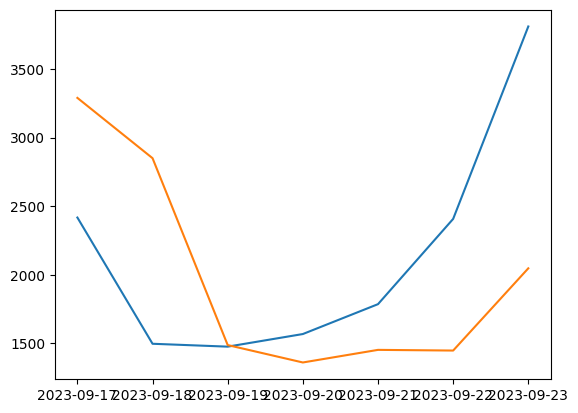

In [51]:
# plot predictions vs actuals
import matplotlib.pyplot as plt

test_df_4 = test_df[test_df['PULocationID'] == 4]
plt.plot(test_df_4['pickup_date'], test_df_4['count'], label='actual')
plt.plot(test_df_4['pickup_date'], test_df_4['prediction'], label='prediction')
